In [1]:
import DirectDmTargets as dddm

calculating effective efficiency for Xe detector done
calculating effective efficiency for Ge detector done
calculating effective efficiency for Ar detector done
calculating effective efficiency for Xe_migd detector done
calculating effective efficiency for Ge_migd detector done
calculating effective efficiency for Ar_migd detector done


In [2]:
import time

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from tqdm import tqdm

In [5]:
import numericalunits as nu

In [6]:
import wimprates as wr

# Finding the correct 'factor' #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

25 october 2019 

## Goal ## 
- in the DetectorSpectrum-class a factor is used to rebin the DM-spectrum. This rebinning should be fine enough to allow the numerical integration to be sufficiently accurate. However we don't want a too fine binning as it does increase computation time drastically. 

## Result ##
A factor (the factor between the the bins used for the numerical integration and the spectrum) is set to **10** as this proved a fair trade off between speed and accuracy.

(1e-07, 10000000000.0)

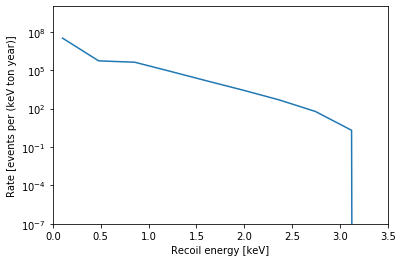

In [7]:
# NR's
energies = np.linspace(0.1, 3.5, 10)

# dr/dr
dr = ((nu.keV * (1000 * nu.kg) * nu.year) * 
    wr.rate_migdal(energies * nu.keV, 
                    mw=1 * nu.GeV/nu.c0**2, 
                    sigma_nucleon=1e-35 * nu.cm**2))

plt.plot(energies, dr, label="WIMPrates SHM")

plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")

plt.xlim(0, energies.max())
plt.yscale("log")

plt.ylim(1e-7,1e10)
# dr

## Distribution of the DM ##
First we need to make a DM-rate spectrum (below we first compare the un-smeared and smeared spectrum)

In [8]:
use_SHM = dddm.SHM()

In [9]:
# No detector resolution
def plot_spectrum(data, yerr = True, color = 'blue', label = 'label', linestyle = 'none'):
    plt.errorbar(data['bin_centers'], data['counts'], 
                xerr=(data['bin_left'] - data['bin_right'])/2,
                yerr = np.sqrt(data['counts']) if yerr else np.zeros(len(data['counts'])),
                color = color,
                linestyle = linestyle,
                capsize = 2,
                marker = 'o',
                label = label
                )
def plot_spectrum_ax(ax, data, yerr = True, color = 'blue', label = 'label', linestyle = 'none'):
    ax.errorbar(data['bin_centers'], data['counts'], 
                xerr=(data['bin_left'] - data['bin_right'])/2,
                yerr = np.sqrt(data['counts']) if yerr else np.zeros(len(data['counts'])),
                color = color,
                linestyle = linestyle,
                capsize = 2,
                marker = 'o',
                label = label
                )
def get_gal_spec(det, mw = 1, sigma = 1e-35, nbins = 10):
    events = dddm.GenSpectrum(mw, sigma, use_SHM, dddm.experiment[det])
    events.n_bins = nbins
    return events.get_data(poisson = False)

In [10]:
def get_det_spec(det, mw = 1, sigma = 1e-35, nbins = 10, background = True,):
    events = dddm.DetectorSpectrum(mw, sigma, use_SHM, dddm.experiment[det])
    events.n_bins = nbins
    events.add_background = background
    return events.get_data(poisson = False)

In [11]:
plt.rcParams['axes.grid'] = True

def plot_spectra(det, mw = 1, sigma = 1e-35, nbins = 10):
    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, figsize = (14,14), sharex = True)
    
    gal_spec = get_gal_spec(det, mw = mw, sigma = sigma, nbins = nbins)
    bg_spec = get_det_spec(det, mw = mw, sigma = sigma, nbins = nbins)
    no_bg_spec = get_det_spec(det, mw = mw, sigma = sigma, nbins = nbins, background = False)
    
    plot_spectrum_ax(ax1, gal_spec, color = 'red', 
                     label = f'{det} without det. parameters (gal_spec)')
    
    plot_spectrum_ax(ax1,bg_spec,color =  'black', 
                     label = f'{det} with background (bg_spec)')
   
    plot_spectrum_ax(ax1,no_bg_spec,color =  'blue', 
                     label = f'{det} without background (no_bg_spec)')
    
    ax1.set_ylim(bottom=np.max([plt.ylim()[-1], (1e-10 * 10/nbins)]))
#     ax1.legend()
    
    
#     ax1.set_ylim(np.min(no_bg_spec['counts'].values), 
#                  np.max(bg_spec['counts'].values) * 1.5)
    ax1.set_yscale("log")
#     ax1.grid(axis="both")
    
    plot_spectrum_ax(ax2, gal_spec, color = 'red', 
                     label = f'{det} without det. parameters')
    plot_spectrum_ax(ax2,bg_spec,color =  'black', 
                     label = f'{det} with background')
    plot_spectrum_ax(ax2,no_bg_spec,color =  'blue', 
                     label = f'{det} without background')
#     ax2.legend()
#     ax2.grid(axis="both")
    
    diff_bg = bg_spec.copy()
    diff_bg['counts'] = bg_spec['counts'] - no_bg_spec['counts']
    plot_spectrum_ax(ax3, diff_bg, color = 'orange',yerr = False, 
                     label = f'{det} background (bg - no_bg)')
#     ax3.legend()
#     ax3.grid(axis="both")
   
    diff_gal = gal_spec.copy()
    diff_gal['counts'] = gal_spec['counts'] - no_bg_spec['counts']
    plot_spectrum_ax(ax4,diff_gal, color = 'green', yerr = False, 
                     label = f'{det} gal-spec diff (gal. - no_bg)')
#     ax4.legend()
#     ax4.grid(axis="both")
    
    for ax in [ax1,ax2,ax3, ax4]:
        ax.axvline(dddm.experiment[det]['E_thr'], label = 'energy threshold')
        ax.grid(axis="both")
        ax.legend()

Wall time: 15.9 s


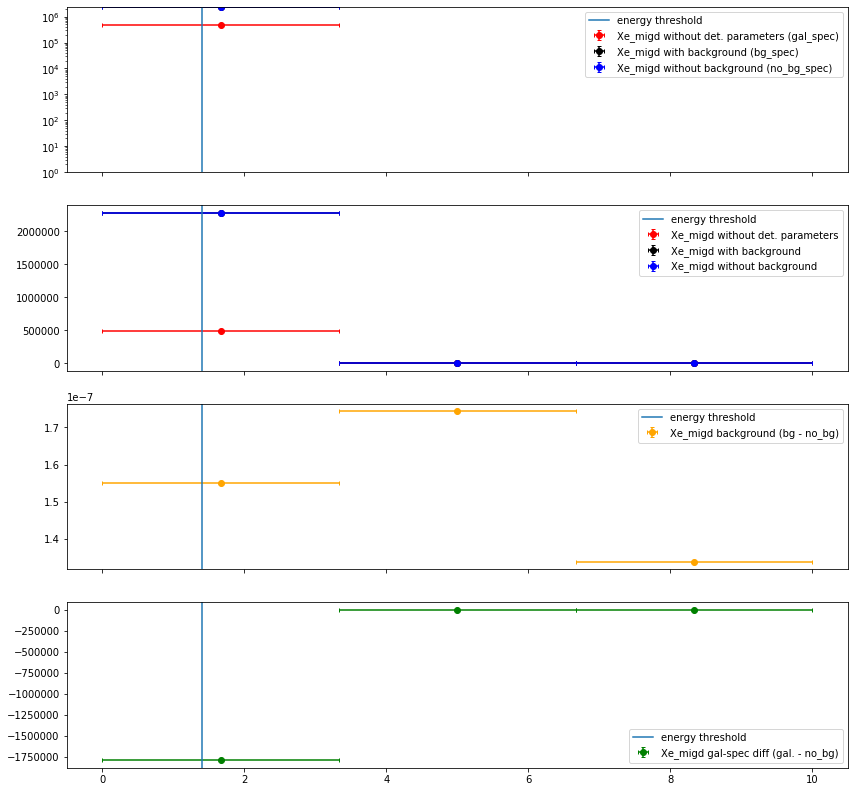

In [12]:
%%time
def temp_res(E):
    return 0.006 * np.sqrt(E)
dddm.experiment['Xe_migd']['res'] = temp_res
plot_spectra('Xe_migd', nbins = 3)

Wall time: 2min 24s


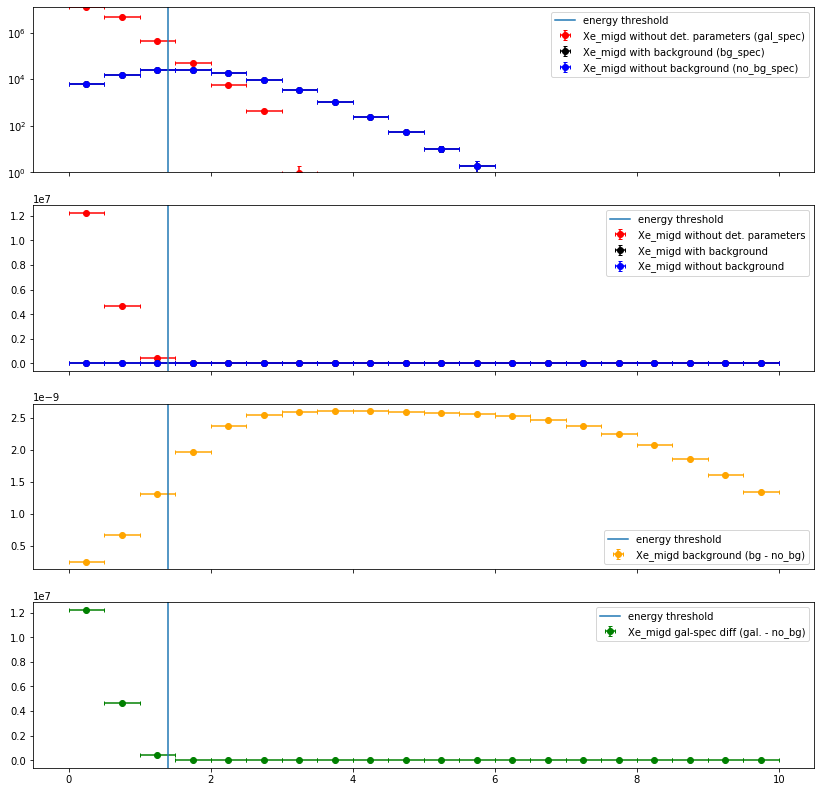

In [13]:
%%time
dddm.experiment['Xe_migd']['res'] = dddm.det_res_XENON1T
plot_spectra('Xe_migd', nbins = 20)

In [14]:
dddm.experiment['Xe_migd']['E_thr']

1.4

Wall time: 45.3 s


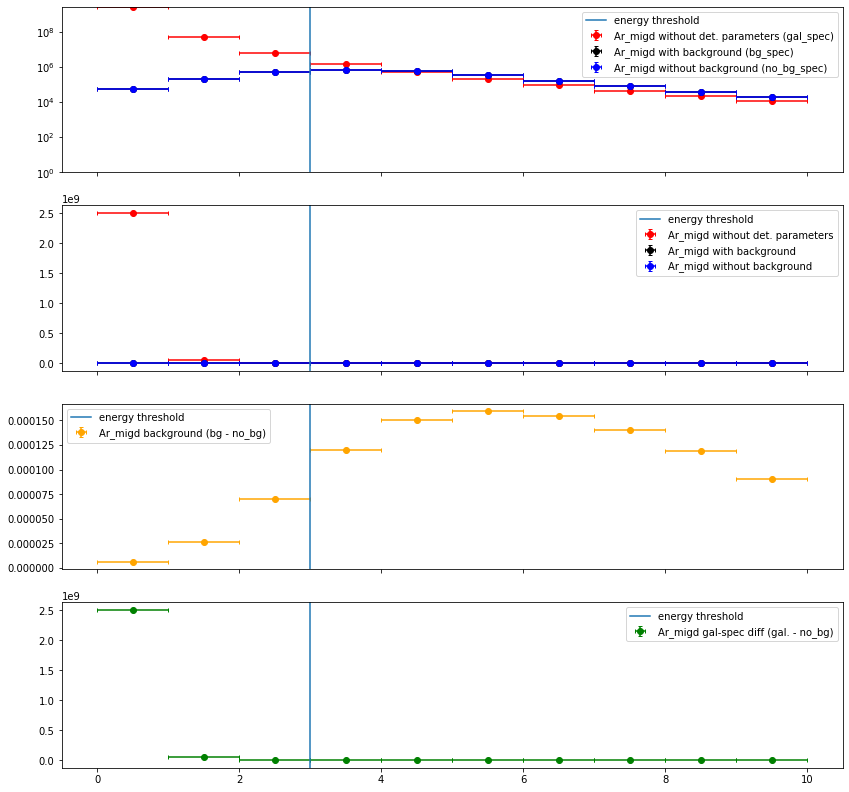

In [15]:
%%time
plot_spectra('Ar_migd', 10)

Wall time: 1min 12s


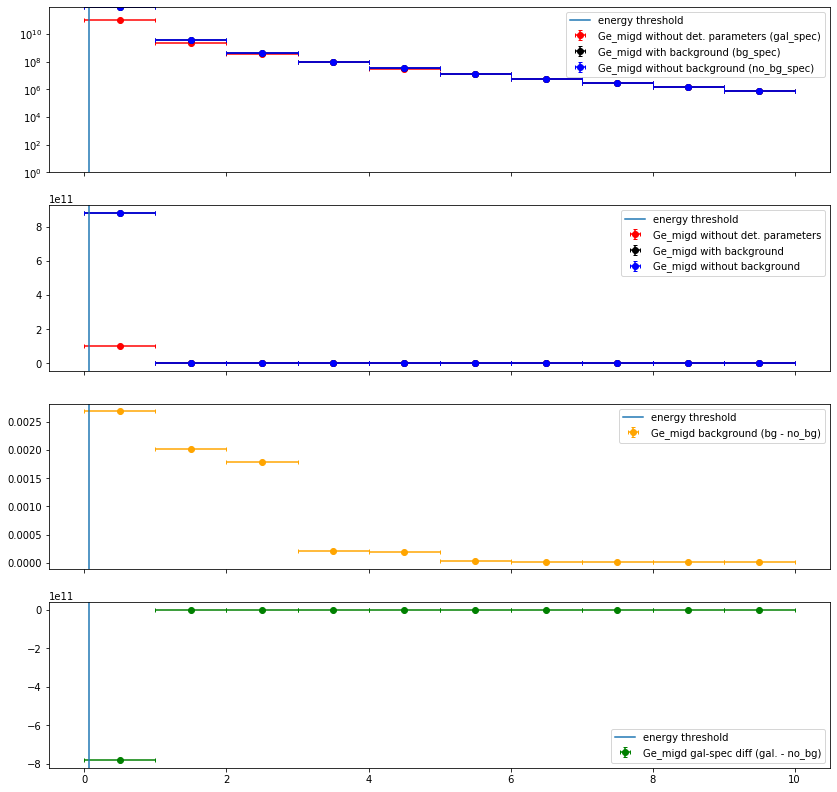

In [16]:
%%time
plot_spectra('Ge_migd', 10)

-- mw = 0.1 for Ge_migd -- 


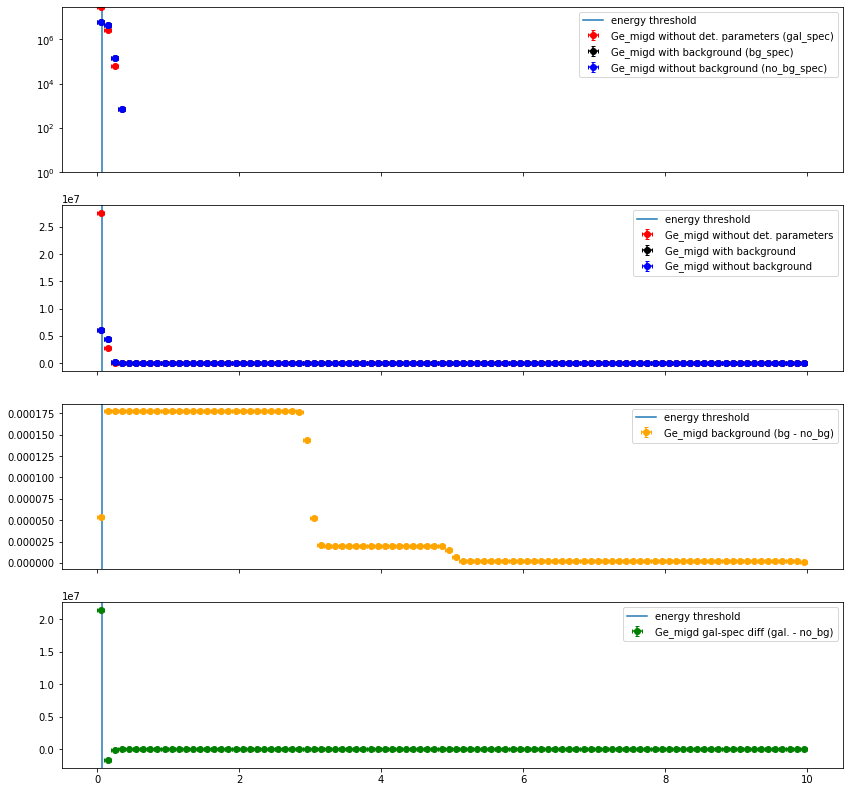

done in 291.6144959926605 s = 4 m

-- mw = 0.1 for Ge_migd -- 


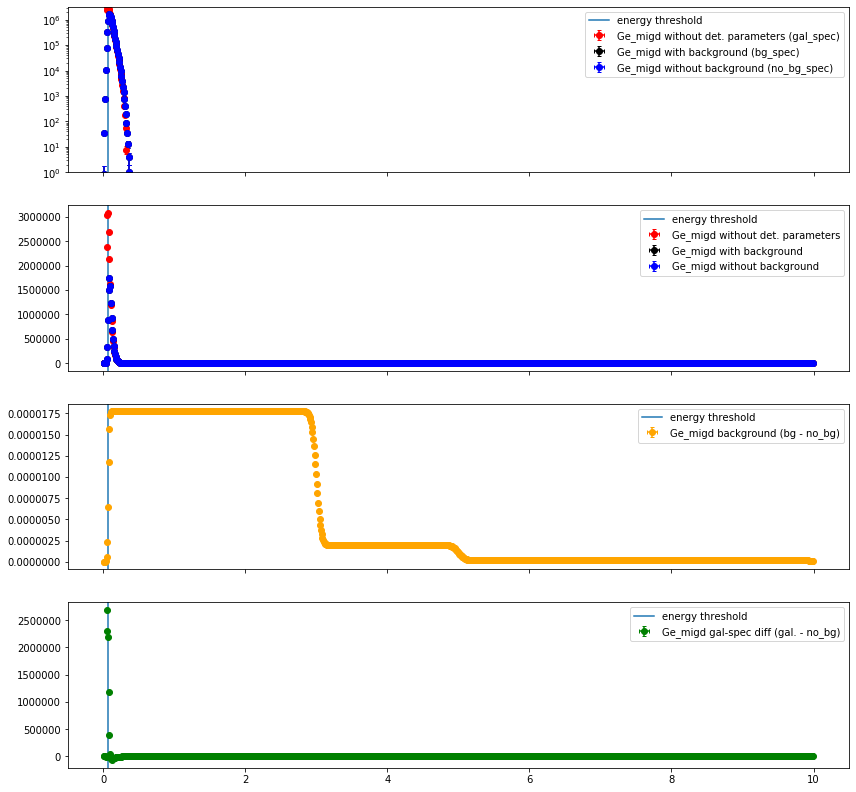

done in 2910.98979473114 s = 48 m

-- mw = 0.1 for Xe_migd -- 


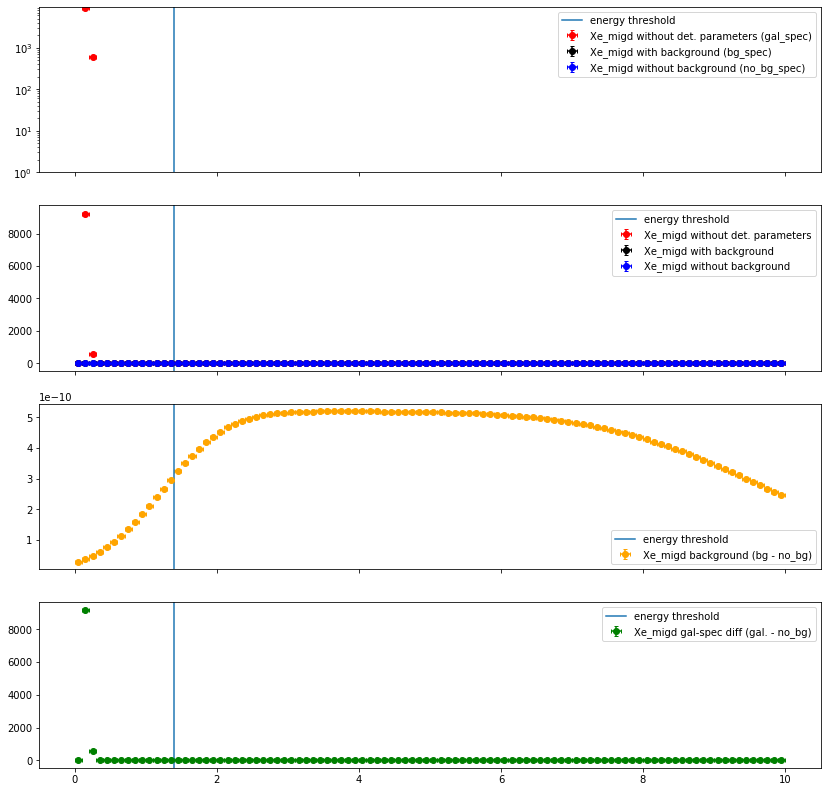

done in 442.8516688346863 s = 7 m

-- mw = 0.1 for Ar_migd -- 


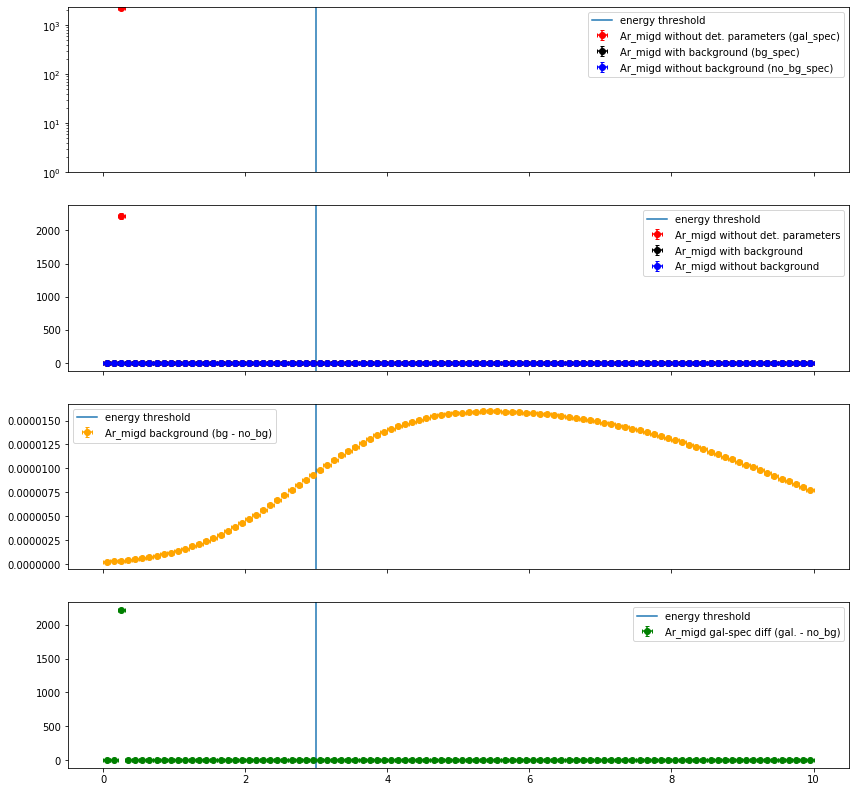

done in 169.31131219863892 s = 2 m

-- mw = 1 for Ge_migd -- 


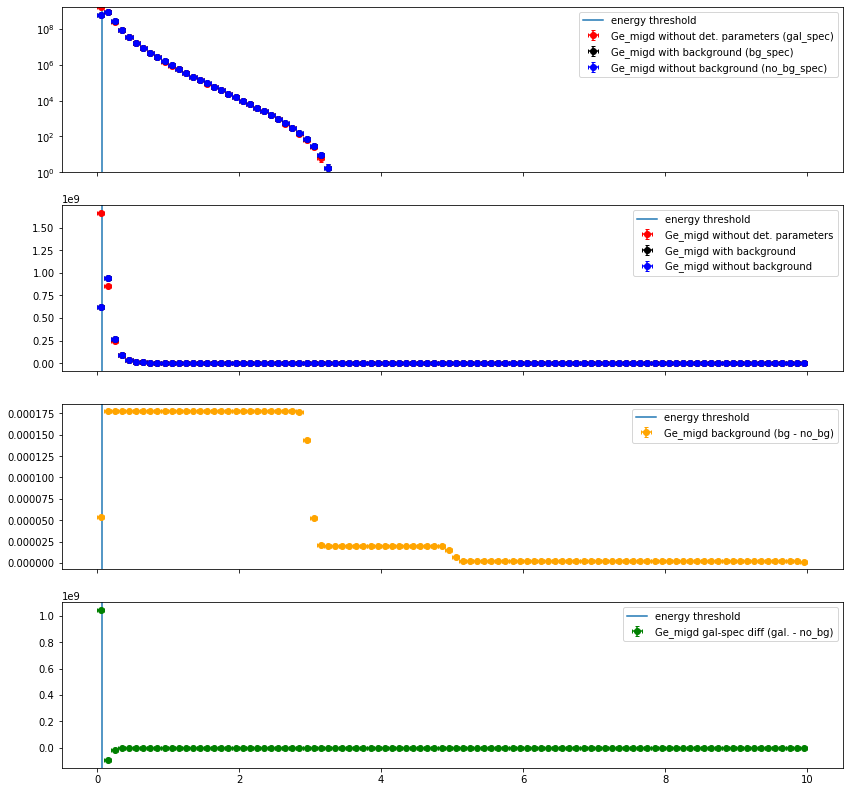

done in 301.818496465683 s = 5 m

-- mw = 1 for Ge_migd -- 


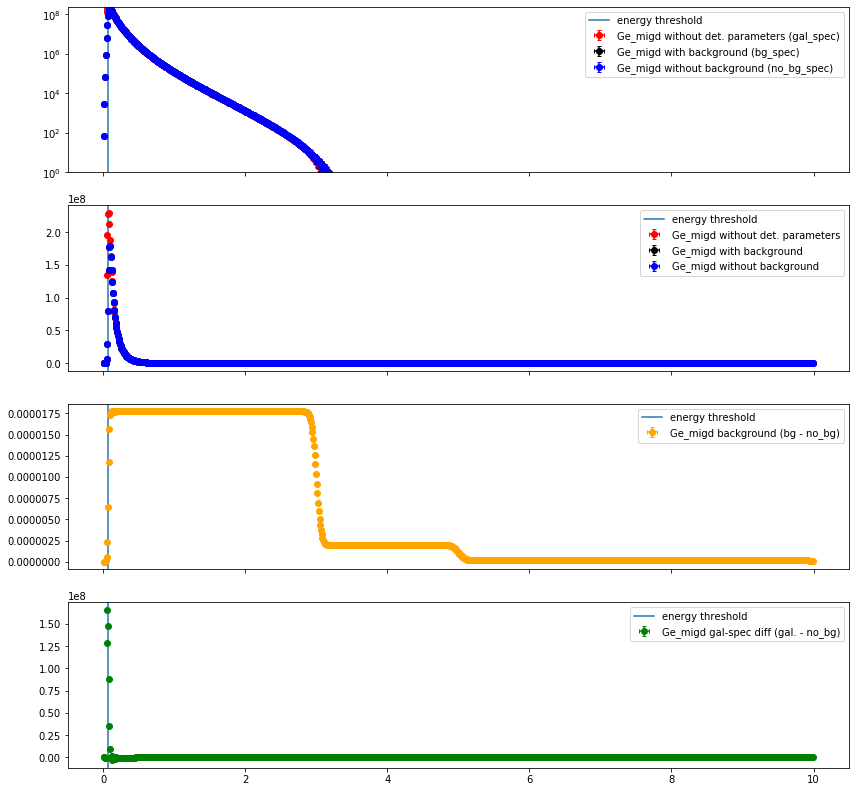

done in 2613.0595993995667 s = 43 m

-- mw = 1 for Xe_migd -- 


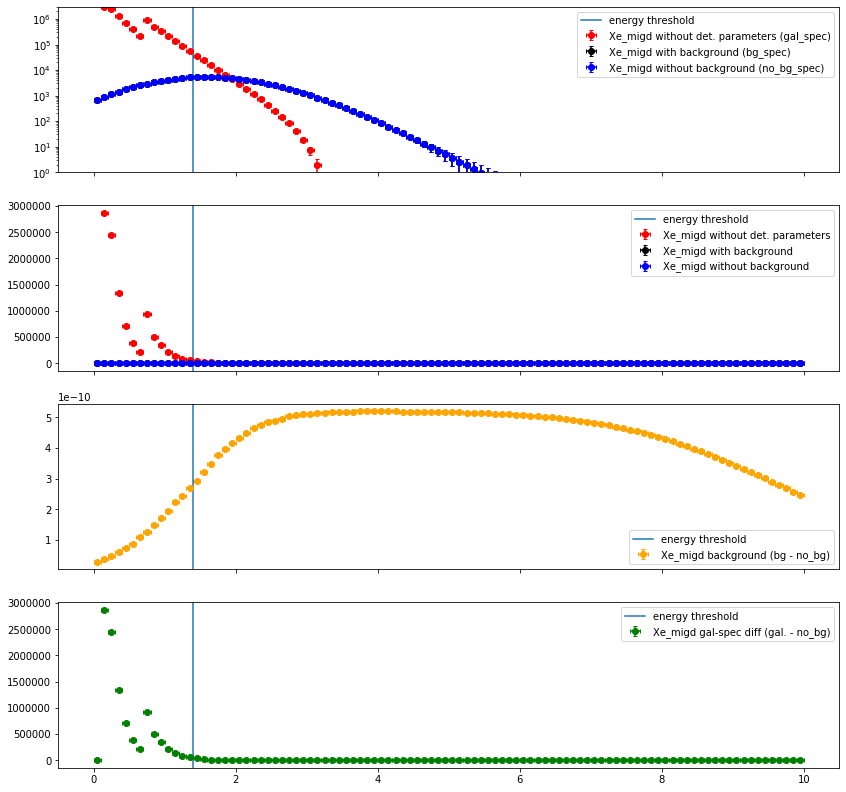

done in 474.4315903186798 s = 7 m

-- mw = 1 for Ar_migd -- 


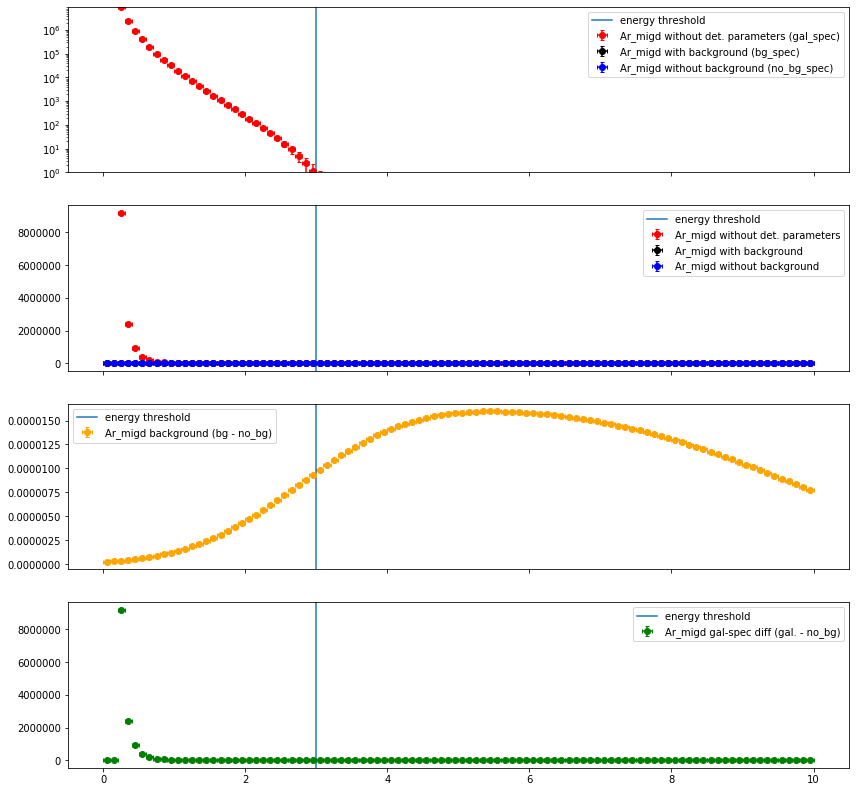

done in 189.8444402217865 s = 3 m

-- mw = 5 for Ge_migd -- 


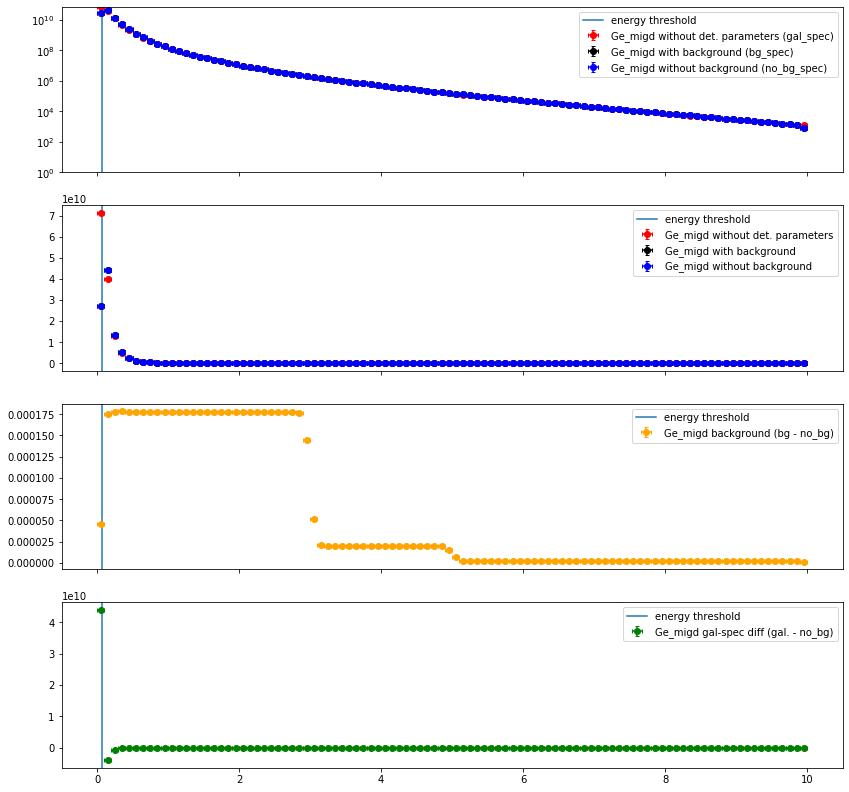

done in 435.72776317596436 s = 7 m

-- mw = 5 for Ge_migd -- 


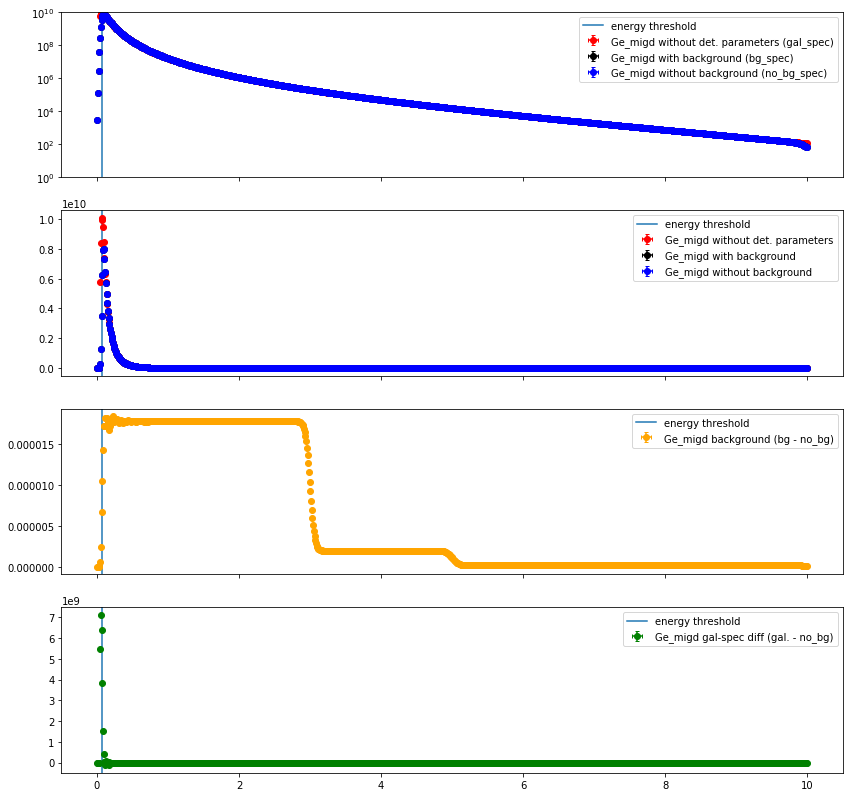

done in 4389.728000164032 s = 73 m

-- mw = 5 for Xe_migd -- 


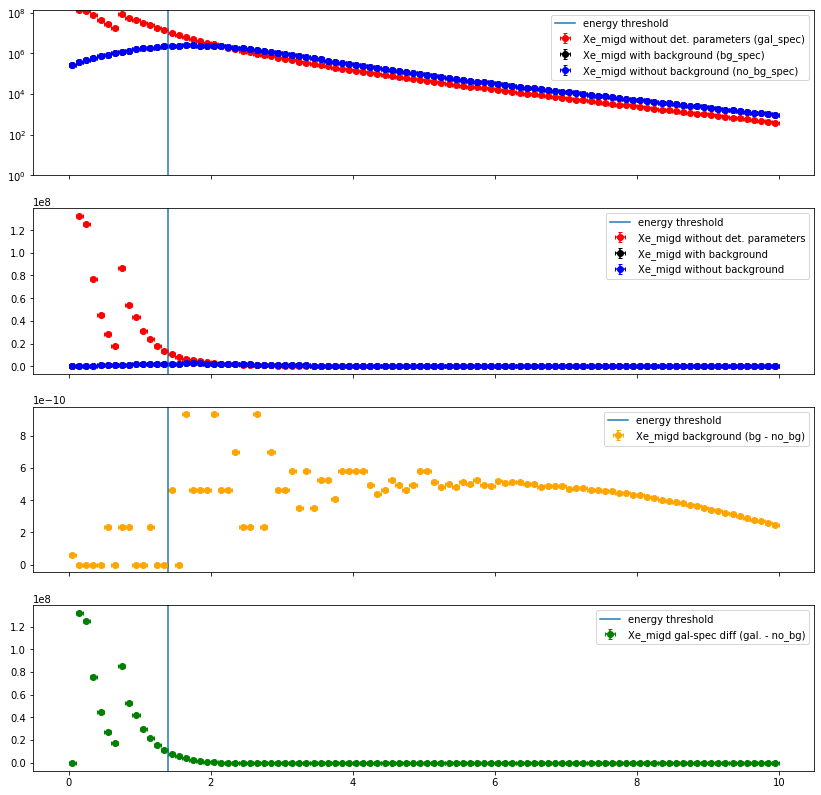

done in 864.8142275810242 s = 14 m

-- mw = 5 for Ar_migd -- 


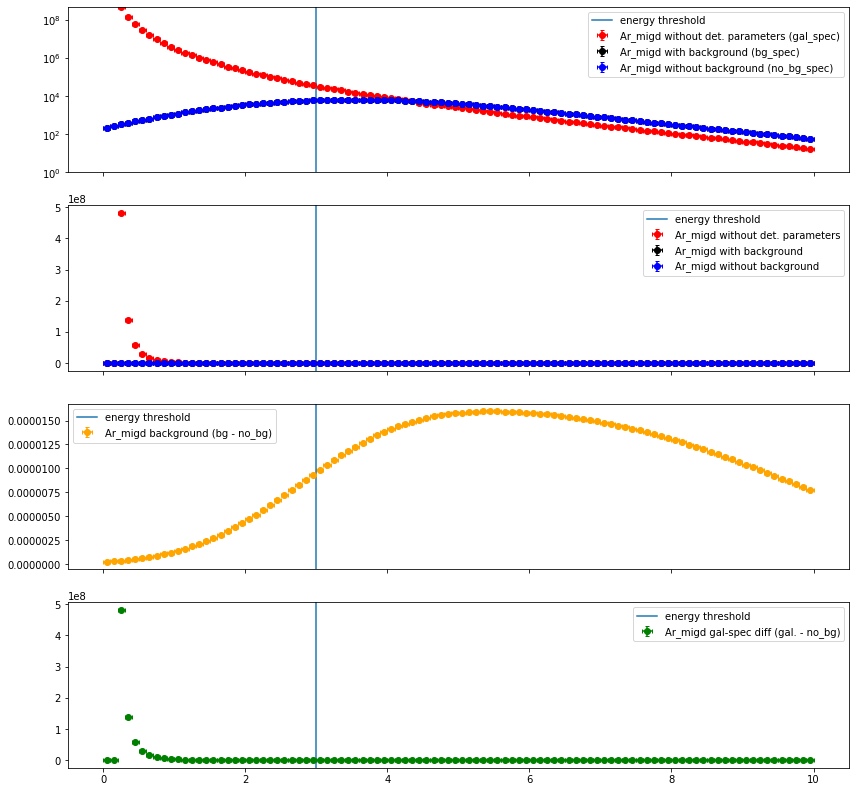

done in 304.07379388809204 s = 5 m



In [17]:
n_bins_dict = {'Ge_migd':[100, 1000], 'Xe_migd':[100], 'Ar_migd':[100]}
for mw in [0.1, 1, 5]:
    for det in ['Ge_migd', 'Xe_migd', 'Ar_migd']:
        for nbins in n_bins_dict[det]:
            t0 = time.time()
            print(f'-- mw = {mw} for {det} -- ')
            plot_spectra(det, mw = mw, nbins = nbins)
            for f_type in  ['png', 'pdf']:
                plt.savefig(f'figures/spectrum_{det}_mw-{mw}_nbin-{nbins}.{f_type}', dpi = 100)
            plt.show()
            print(f'done in {time.time() -t0} s = {int((time.time() -t0)/60)} m')
            print()

In [18]:
assert False

AssertionError: 

## Finding the correct factor ##

In [ ]:
stats_ge = dddm.NestleStatModel("Ge")
stats_ge.get_summary()

In [ ]:
stats_ge.check_spectrum()

In [ ]:
stats_xe = dddm.NestleStatModel("Xe")
stats_xe.get_summary()

In [ ]:
stats_xe.check_spectrum()

In [ ]:
stats_ar = dddm.NestleStatModel("Ar")
stats_ar.get_summary()

In [ ]:
stats_ar.check_spectrum()